This file processes the trajectory data in order to calculate and save metrics and histograms.  This is included for completeness but is not needed to reproduce the results in the paper (output of this code is included in the data repository)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import gzip
import os
import gc
import multiprocessing
# from sknetwork.embedding import Spectral, BiSpectral
# import sknetwork

import scipy.stats  

In [2]:
# import definitions_2018 as bd
year = 2019
workstation=163  #[0=local/github, 162,163 for servers]

if workstation==163:
    %cd '/sharedcodes/bees/code/'    
else:
    None # for github/local, working directory is this one

if year==2018:
    import definitions_2018 as bd
    if workstation==163:
        resultsdir = '/data/beeresults/'
        comb_contents_dir = '/data/comb-contents-images/'
    elif workstation==0:
        resultsdir = 'data2018/'
        comb_contents_dir = 'comb-contents2018/'         
    zfilln = 2 # for file names
elif year==2019:
    import definitions_2019 as bd
    if workstation==163:
        resultsdir = '/data/beeresults2019/'
        comb_contents_dir = '/data/comb-contents-images2019/'
    elif workstation==0:
        resultsdir = 'data2019/'
        comb_contents_dir = 'comb-contents2019/'               
    zfilln = 3 # for file names    
    
import displayfunctions as bp  # 'bee plots'
import datafunctions as dfunc
dfunc.init(bd) 
bp.init(bd)
bd.year

/home/jdavidson/bees_sharedcodes/Bees_sharedcodes


/home/jdavidson/bees_sharedcodes/Bees_sharedcodes/JD-2018-Github/definitions_2019.py:27: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  cohort_birthdates = np.array([pd.Timestamp(np.array(cohort_data['DOB'][cohort_data['cohort']==c])[0],freq='D') for c in cohort_colornames])


2019

# (0) Save the combs for each day as a condensed data structure that is faster to read in

In [3]:
# for daynum in range(bd.numdays):
#     print(daynum)
#     comb = dfunc.day_comb_data(comb_contents_dir,daynum)
#     pickle.dump(comb,gzip.open(comb_contents_dir+'comb_'+str(daynum).zfill(zfilln)+'.pklz','wb'))
    

# (0.2) Calculate overall comb substrate fractions and save

In [4]:
def calc_overall_substrates(comb):
    overall_comb_substrates = np.zeros(bd.numsubstrates)
    w = [1,0] if comb.nummaps==1 else comb.weights
    for snum in range(bd.numsubstrates):
        overall_comb_substrates[snum] = np.mean(comb.substrate_maps[0]==snum) if comb.nummaps==1 else (np.mean(comb.substrate_maps[0]==snum)*w[0] + np.mean(comb.substrate_maps[1]==snum)*w[1])
    return overall_comb_substrates

In [ ]:
print(bd.comb_daynums)
substrates = []
for daynum in bd.comb_daynums:
    print(daynum)
#     comb = dfunc.day_comb_data(comb_contents_dir,bd.alldaytimestamps[daynum])
    comb = pickle.load(gzip.open(comb_contents_dir+'comb_'+str(daynum).zfill(zfilln)+'.pklz','rb'))
#     bp.showcomb(comb)
#     plt.title(bd.alldaytimestamps[daynum],fontsize=20)
#     plt.show()
    subs = calc_overall_substrates(comb)
    substrates.append(subs)

In [8]:
if year==2018:
    dancefloorcomb,hull = pickle.load(gzip.open(comb_contents_dir+'combined_dancefloor.pklz','rb'))  
    dancesubs = calc_overall_substrates(dancefloorcomb)

In [16]:
# Store the overall substrates in a day-format
all_overall_comb_substrates = np.zeros((bd.numdays,bd.numsubstrates))
all_overall_comb_substrates[bd.comb_daynums,:] = substrates
if year==2018:
    all_overall_comb_substrates[:,5] = dancesubs[5]
# linear interpolation between the comb measurements
days_to_use = bd.comb_daynums
for i in range(len(days_to_use)-1):
    d1 = days_to_use[i]
    d2 = days_to_use[i+1]
    for snum in range(bd.numsubstrates):
        interp = np.interp(np.arange(d1,d2+1),[d1,d2],[all_overall_comb_substrates[d1,snum],all_overall_comb_substrates[d2,snum]])
        all_overall_comb_substrates[d1:d2,snum] = interp[:-1]
        
# for the last measurement, set all equal to it
all_overall_comb_substrates[bd.comb_daynums[-1]:] = all_overall_comb_substrates[bd.comb_daynums[-1]]

# save to file
pickle.dump([all_overall_comb_substrates],open(resultsdir+'all_overall_comb_substrates.pkl','wb'))

# (1) Bee-TimeDiv Data

In [20]:
# days lived - import this, because will use to only save data for bees that were alive on a given day
# This is processed in '2- Create Data Matrix', separately for each year
[cohort_daysalive] = pickle.load(open(resultsdir+'daysalive.pkl','rb'))
uid_daysalive = np.concatenate(cohort_daysalive)


if year==2018:
    dancefloorcomb,hull = pickle.load(gzip.open(comb_contents_dir+'combined_dancefloor.pklz','rb'))

##  Data processing to calculate metrics

In [22]:
max_delay = 1 # in seconds - don't calculate speed or turning velocity if speed if delay is greater than this
time_outside_trip = 60*10  # seconds
min_num_obs_for_calc=10  # min number of obs in an hour to calculate quantities for that hour.  If don't have any data points, then the calculations don't make sense
 

def calc_quantities_for_timenum_data(data):
    saveminuteaverages=False
# loop over time divisions
#     for timenum in range(numtimedivs):      
#         print(timenum)

    [day_uids,[startframe,endframe,minperdiv],numbees_this_day,all_uids,all_camera,all_x,all_y,all_framenums,all_subs] = data

    # NOTE:  numpy is way faster than pandas for these type of repeated 'mask' selections'.  by ~100 ms per id, which is very significant for a loop        

    bee_subhists = np.zeros((numbees_this_day,2,bd.numsubstrates))
    bee_subhists_minute = np.zeros((numbees_this_day,2,bd.numsubstrates))
    bee_framehist = np.zeros((numbees_this_day,2,3))

    bee_xyhist = np.zeros((numbees_this_day,bd.numxbins,bd.numybins))
    bee_speedhist = np.zeros((numbees_this_day,bd.numxbins,bd.numybins))

    bee_xyhist_minute = np.zeros((numbees_this_day,bd.numxbins,bd.numybins))
    bee_speedhist_minute = np.zeros((numbees_this_day,bd.numxbins,bd.numybins))

    bee_fromcenter_stats = np.zeros((numbees_this_day,2))  # [mean - hour, mean - minute]  - This is dispersion
    bee_position = np.zeros((numbees_this_day,2))  # [x,y] (flat) mean position for most common camera
    bee_speed_stats = np.zeros((numbees_this_day,3))  # [median, iqr, movingfraction]
    bee_exitdist_stats = np.zeros((numbees_this_day,4)) # [mean, std, median, iqr]
    bee_numobs = np.zeros((numbees_this_day))
    bee_numtrips = np.zeros((numbees_this_day))
    bee_numdancefloorvisits = np.zeros((numbees_this_day))
    bee_numframecrossings = np.zeros((numbees_this_day,6,6))


    if len(all_x)>0:
        # loop over bees:  Get quantities per-hour
        for beenum, bee_uid in enumerate(day_uids):
            beesel = all_uids==bee_uid
            numobs = np.sum(beesel)
            if numobs>=min_num_obs_for_calc:

                camera = all_camera[beesel]
                x = all_x[beesel]
                y = all_y[beesel]
                framenums = all_framenums[beesel]

                framenums -= startframe
                minutebin_edges = np.linspace(0,minperdiv,minperdiv+1)*60*3
                intbins = np.arange(-0.5,bd.numsubstrates,1)   

                # amount of observations on substrate
                subs = [s[beesel] for s in all_subs]
                # override the individual substrates with the dance floor substrates - only for 2018!
                # DON'T DO THIS FOR 2019, BECAUSE THE DANCE FLOOR DOES NOT HAVE A GOOD DEFINITION YET
                if year==2018:
                    dancesubs = dancefloorcomb.getsubstrate(camera,x,y)
                    for j in range(len(subs)):
                        subs[j][dancesubs[0]==5] = 5

                # Dispersion:  root mean square dist from center point, consider 2D nest as 'flat'
                x_flat, y_flat = dfunc.shift_and_flatten_pixels(x,y,camera)
                flatdist = dfunc.getflatdistance(x,y,camera)
                dist_from_mean = np.sqrt((x_flat-np.mean(x_flat))**2 + (y_flat-np.mean(y_flat))**2)
                fromcenter_mean =  np.mean(dist_from_mean)

                # speed
                dtimes = np.diff(framenums).astype(float) * 1/3  # convert framenumbers convert to sec
                samecamera = (np.diff(camera) == 0)
                speed = flatdist / dtimes
                speed[np.logical_not(samecamera)|(dtimes>max_delay)] = np.nan  # don't count the switching camera ones, or when the delay is large
                speed[dtimes==0] = np.nan # just in case there are some zero differences (I think I filtered these out though)

                speed_median = np.nanmedian(speed)
                speed_iqr = np.nanquantile(speed,0.75) - np.nanquantile(speed,0.25)
                speed_quantile90 =  np.nanquantile(speed,0.90)

                # distance from exit
                exitdist = dfunc.getexitdistance(x,y,camera)
                exitdist_mean, exitdist_std = np.mean(exitdist), np.std(exitdist)
                exitdist_median, exitdist_iqr = np.median(exitdist), np.quantile(exitdist,0.75) - np.quantile(exitdist,0.25)                    

                # histograms: simple, giving equal weight in the averaging to each point
                subhists = [np.histogram(s,bins=intbins)[0] for s in subs]
                framehist = dfunc.getframehist(x,y,camera)
                xyhist = dfunc.getxyhist(x,y,camera)
                speedhist = dfunc.getspeedhist(x,y,camera)   # returns shape (41, 35)

                # per-minute histograms and dispersion:  give equal weight in the averaging to each minute, not to each point                 
                if saveminuteaverages:
                    xyhist_minute = []
                    speedhist_minute = []
                    subhists_minute = []
                    dispersion_minute = []
                    for j in range(minperdiv):  # for 60 minutes in the hour
                        tsel = (minutebin_edges[j]<=framenums) & (framenums<minutebin_edges[j+1])
                        numpoints = np.sum(tsel)
                        if numpoints>0:
                            xyhist_minute.append(dfunc.getxyhist(x[tsel],y[tsel],camera[tsel])/numpoints)
                            subhists_minute.append([np.histogram(s[tsel],bins=intbins)[0]/numpoints for s in subs])
                        if numpoints>1:
                            speedhist_minute.append(dfunc.getspeedhist(x[tsel],y[tsel],camera[tsel])/numpoints)
                        if numpoints>2:
                            x_flat, y_flat = dfunc.shift_and_flatten_pixels(x[tsel],y[tsel],camera[tsel])
                            flatdist = dfunc.getflatdistance(x[tsel],y[tsel],camera[tsel])
                            dist_from_mean = np.sqrt((x_flat-np.mean(x_flat))**2 + (y_flat-np.mean(y_flat))**2)
                            dispersion_minute.append(np.mean(dist_from_mean))
                    # note:  multiply histograms by numobs, to 'un-normalize'
                    subhists_minute = np.mean(subhists_minute,axis=0) * numobs
                    xyhist_minute = np.mean(xyhist_minute,axis=0) * numobs
                    speedhist_minute = np.nanmean(speedhist_minute,axis=0) * numobs # this can have nans - it returns nan if no entries
                    # don't multiply dispersion by numobs
                    dispersion_minute = np.nanmean(dispersion_minute,axis=0)
                else:
                    dispersion_minute = np.nan

                # Num Outside Trips (approx measure)
                numtrips = 0
                longbreaks = np.where(dtimes>=time_outside_trip)[0]
                for breakind in longbreaks:
                    # if was in the frame 5 before not being seen, count as a trip
                    if dfunc.getframehist(x[breakind],y[breakind],camera[breakind])[-1,-1] == 1:
                        numtrips = numtrips+1
                # check for a trip at the end
                if dfunc.getframehist(x[-1],y[-1],camera[-1])[-1,-1] == 1:
                    # if end 'trip' is more than the outside trip time to the end, count it
                    if (endframe-startframe - framenums[-1]) > time_outside_trip*3:
                        numtrips = numtrips+1                                

                # Dance floor visits
                # dance floor is the same in each comb measurement, so just take the first one
                dcrossings = 0
                changes = np.where(np.abs(np.diff(subs[0]))>0)[0]
                for c in changes:
                    # count coming TO the dance floor only
                    if subs[0][c+1]==5:
                        dcrossings += 1

                # Observation hive Frame crossings
                framehistvalues = dfunc.getframehistvalues(x,y,camera)
                crossings = np.zeros((6,6))
                changes = np.where(np.abs(np.diff(framehistvalues))>0)[0]
                for c in changes:
                    crossings[framehistvalues[c+1],framehistvalues[c]] += 1

                # Mean x and y position during most common camera
                x_adjusted = x + (np.logical_not(camera).astype(int))*bd.xpixels
                camselval = 0 if (np.sum(camera==0)>=np.sum(camera==1)) else 1
                camsel = (camera==camselval)
                meanx, meany = np.mean(x_adjusted[camsel]), np.mean(y[camsel])
                
                bee_subhists[beenum] = subhists
                bee_framehist[beenum] = framehist
                bee_xyhist[beenum] = xyhist
                bee_speedhist[beenum] = speedhist
                if saveminuteaverages:
                    bee_subhists_minute[beenum] = subhists_minute
                    bee_xyhist_minute[beenum] = xyhist_minute
                    bee_speedhist_minute[beenum] = speedhist_minute

                bee_fromcenter_stats[beenum] = [fromcenter_mean, dispersion_minute]
                bee_position[beenum] = [meanx, meany]
                bee_speed_stats[beenum] = [speed_median, speed_iqr, speed_quantile90]
                bee_exitdist_stats[beenum] = [exitdist_mean, exitdist_std, exitdist_median, exitdist_iqr]
                bee_numobs[beenum] = numobs
                bee_numtrips[beenum] = numtrips
                bee_numdancefloorvisits[beenum] = dcrossings
                bee_numframecrossings[beenum] = crossings


            # within for loop for individual bees
        # under if len(dftimenum)>0
    # this will return arrays of all zeros, if nothing is there
    return [bee_subhists, bee_framehist, bee_xyhist, bee_speedhist, bee_fromcenter_stats, bee_position,
                    bee_speed_stats, bee_exitdist_stats, bee_numobs, bee_numtrips, bee_numdancefloorvisits, bee_numframecrossings]

def processday_parallel(daynum,numtimedivs,saveminuteaverages=False,nprocesses=4):
    if numtimedivs==24:
        prefix = 'dayhour'
    elif numtimedivs==288:
        prefix = 'day5min'
    else:
        prefix = 'day1min' 
        
    minperdiv = np.floor(24*60 / numtimedivs).astype(int)  
    
    day = bd.alldaytimestamps[daynum]
    print('day: ',day)    
#     comb = dfunc.day_comb_data(comb_contents_dir,daynum)
    comb = pickle.load(gzip.open(comb_contents_dir+'comb_'+str(daynum).zfill(3 if year==2019 else 2)+'.pklz','rb'))
    
    savefile = resultsdir+'beetrajectories_skip'+str(1)+'_'+str(daynum).zfill(3)+'.pklz'
    df = pickle.load(gzip.open(savefile,'rb'))
    day_uids = np.unique(df['uid']).astype(int).copy()  # this includes only bees that were alive this day - see '2019 - DBquery'    
    numbees_this_day = len(day_uids)
    df.sort_values(by=['framenum'],inplace=True)  # because below, will assume this is sequential in time

  
    print('Dividing data from the df...')
    datas=[]
    dfframenums = np.array(df['framenum']).astype(int)
    for timenum in range(numtimedivs):
        framesperdiv = int(3*60*60*24 / numtimedivs)
        startframe = timenum*framesperdiv
        endframe = (timenum+1)*framesperdiv        
        dftimenum = df.iloc[(dfframenums>=startframe) & (dfframenums<endframe)]  # iloc = "integer location"
#         dftimenum = df[(df['framenum']>=startframe) & (df['framenum']<endframe)]  # its way faster to use numpy - 10sec pandas, vs 0.3 sec numpy
        all_uids = np.array(dftimenum['uid']).astype(int)
        all_camera = np.array(dftimenum['camera']).astype(int)
        all_x = np.array(dftimenum['x']).astype(int)
        all_y = np.array(dftimenum['y']).astype(int)
        all_framenums = np.array(dftimenum['framenum']).astype(int)
        all_subs = comb.getsubstrate(all_camera,all_x,all_y)
        datas.append([day_uids,[startframe,endframe,minperdiv],numbees_this_day, all_uids,all_camera,all_x,all_y,all_framenums,all_subs])
        
    del df
    gc.collect()
    
    print('Parallel calculations for quantities')
    pool = multiprocessing.Pool(processes=nprocesses)
    results = pool.map(calc_quantities_for_timenum_data,datas)
    # SAVE
    day_subhists = np.array([r[0] for r in results])
    day_framehist = np.array([r[1] for r in results])
    day_xyhist = np.array([r[2] for r in results])
    day_speedhist = np.array([r[3] for r in results])
    day_fromcenter_stats = np.array([r[4] for r in results])
    day_position = np.array([r[5] for r in results])    
    day_speed_stats = np.array([r[6] for r in results])    
    day_exitdist_stats = np.array([r[7] for r in results])
    day_numobs = np.array([r[8] for r in results])
    day_numtrips = np.array([r[9] for r in results])
    day_numdancefloorvisits = np.array([r[10] for r in results])
    day_numframecrossings = np.array([r[11] for r in results])    
        
    pool.close()
    
    # not saving these for the parallel version
    day_subhists_minute = []
    day_xyhist_minute = []
    day_speedhist_minute = []
                       
    
    print('writing to file....')
    # output the results for this day as a pkl file
    savefile = resultsdir+'data_'+prefix+'_'+str(daynum).zfill(3)+'.pkl'
    outputlist = [day_subhists,day_subhists_minute,
                 day_framehist,day_xyhist,day_xyhist_minute,day_speedhist,day_speedhist_minute,day_fromcenter_stats,day_position,
                  day_speed_stats,day_exitdist_stats,day_numobs,day_numtrips,day_numdancefloorvisits,day_numframecrossings]
    # don't save xyhist if divisions less than an hour
    if numtimedivs>24:
        outputlist[3] = []
        outputlist[4] = []
        outputlist[5] = []
        outputlist[6] = []
    pickle.dump([day_uids,
        outputlist], gzip.open(savefile,'wb'),protocol=4)
    print('wrote to:', savefile)


In [7]:
# daystoprocess = np.concatenate((bd.heatdays,bd.foragerblockdays_12pm,bd.foragerblockdays_8am,bd.foragerblockdays_2hr,
#                                 bd.foragerblockdays_control,bd.foragerblockdays_reverse,bd.foragerblockdays_x2x2x))

In [7]:
daystoprocess = np.arange(88,bd.numdays)

In [ ]:
nprocesses = 5
for daynum in daystoprocess:
#     %time processday_parallel(daynum,numtimedivs=24,nprocesses=nprocesses)
#     gc.collect()
    %time processday_parallel(daynum,numtimedivs=288,nprocesses=nprocesses)
    gc.collect()
    %time processday_parallel(daynum,numtimedivs=1440,nprocesses=nprocesses)
    gc.collect()

# (2)  Create data matrix and save as df for each time division

In [3]:
# daystoprocess = np.concatenate((bd.heatdays-1,bd.heatdays))
# daystoprocess

In [ ]:
# settings:
qn = np.array(['Age','Num. observations','Honey','Brood care','Pollen','Dance floor','Other','Frame 0','Frame 1','Frame 2','Frame 3','Frame 4','Frame 5',
              'Median speed','Speed IQR','Speed 90th quantile','Dispersion (avg)','Exit distance (median)','Fraction squares visited','Day number',
                'Festoon','Empty comb','Mean x-shifted','Mean y',
               'Bee unique ID','Cohort ID',
               'Num. outside trips','Num. dance floor visits','Dispersion-minute avg.',
               'Frame 0 - Num. crossings','Frame 1 - Num. crossings','Frame 2 - Num. crossings','Frame 3 - Num. crossings','Frame 4 - Num. crossings','Frame 5 - Num. crossings'])
numdataquantities = len(qn)
age_ind, obs_ind = 0,1    
alldaynums = np.arange(bd.numdays)

save_xydf = True # if true, saves only for 1 hour, because otherwise its too much

for numtimedivs in [24]:
    if numtimedivs==24:
        prefix = 'dayhour'
        tdcolname = 'Hour'
    elif numtimedivs==288:
        prefix = 'day5min'
        tdcolname = 'timedivision'
    elif numtimedivs==1440: 
        prefix = 'day1min'
        tdcolname = 'timedivision'
    else: 
        print('ERROR:  use either numtimesteps == 24 or 288 or 1440')

    for daynum in daystoprocess:  #  
        print(daynum)
        day = bd.alldaytimestamps[daynum]
        # comb = dfunc.day_comb_data(comb_contents_dir,day)
        # weights = comb.weights if comb.nummaps==2 else np.array([1,0])
        measnums, daydiffs = dfunc.get_closest_measurements(daynum)
        if len(measnums)==1:
            weights = np.array([1,0])
        else:
            weights = 1/daydiffs
            weights = weights/np.sum(weights)


        savefile = resultsdir+'data_'+prefix+'_'+str(daynum).zfill(3)+'.pkl'
        [uids_alive,[day_subhists,day_subhists_minute,
                     day_framehist,day_xyhist,day_xyhist_minute,day_speedhist,day_speedhist_minute,
                    day_fromcenter_stats,day_position,day_speed_stats,day_exitdist_stats,day_numobs,day_numtrips,day_numdancefloorvisits,day_numframecrossings]] = pickle.load( gzip.open(savefile,'rb'))
        uids_alive = uids_alive.astype(int)            

        timecases=np.arange(numtimedivs)    

        cohort_bee_ages = np.concatenate(dfunc.getages(daynum))[uids_alive]  # this also returns -1 if the the bee tag is reused
        cohortids = np.concatenate([(cnum if bd.cohort_birthdates[cnum]<=day else -1)*np.ones(len(bd.cohort_tagids[cnum])) for cnum in range(bd.numcohorts)]).astype(int)        
        cohortids = cohortids[uids_alive]

        # create empty data matrix (filled with nans) to store data for this day
        datamatrix = np.tile(np.nan, (numtimedivs,len(uids_alive),numdataquantities) )
        # 0: age in days
        datamatrix[:,:,age_ind] = cohort_bee_ages[np.newaxis,:]
        # 1:  number of observations
        day_numobs[day_numobs==0] = np.nan  # include these, but mark as nan
        datamatrix[:,:,obs_ind] = day_numobs
        # substrates (2-7)
        weighted_subhists = day_subhists[:,:,0,:]*weights[0] + day_subhists[:,:,1,:]*weights[1]
        datamatrix[:,:,[2,4,5]] = weighted_subhists[:,:,[0,4,5]]  # Honey, Pollen, Dance Floor  
        datamatrix[:,:,3] = weighted_subhists[:,:,1] + weighted_subhists[:,:,2]  # brood as sum of both
        datamatrix[:,:,6] = datamatrix[:,:,obs_ind] - np.sum(datamatrix[:,:,2:6],axis=-1)  # Other
        datamatrix[:,:,2:7] = datamatrix[:,:,2:7]/datamatrix[:,:,obs_ind,np.newaxis]  # Normalized by number of counts
        # frame numbers (7-13)
        datamatrix[:,:,7:13] = np.reshape(day_framehist,(numtimedivs,len(uids_alive),-1))/datamatrix[:,:,obs_ind,np.newaxis] # Normalized by number of counts
        # Speed median, speed IQR, fraction active (13-16)
        datamatrix[:,:,13:16] = day_speed_stats
        # Dispersion, 16 (mean distance from center point)
        datamatrix[:,:,16] = day_fromcenter_stats[:,:,0] #  Distance from center. 0=mean, 1=median
        # Median distance from exit, 17
        datamatrix[:,:,17] = day_exitdist_stats[:,:,2]  # Distance from exit.  0=mean, 1=std, 2=median, 3=iqr
        # Fraction of squares visited, 18
        if numtimedivs==24:
            datamatrix[:,:,18] = np.nansum(day_xyhist>0,axis=(2,3))/(bd.numxbins*bd.numybins)
        # Day number, 19
        datamatrix[:,:,19] = daynum
        # Other histogram quantities, to include in addition to the simple ones
        if year==2019:
            datamatrix[:,:,20] = weighted_subhists[:,:,13]  # Festoon
        datamatrix[:,:,21] = weighted_subhists[:,:,3]  # Empty comb
        # 22 and 23: mean x and mean y in the time division
        datamatrix[:,:,22:24] = day_position
        # UID and cohort ID (24 and 25)
        datamatrix[:,:,np.where(qn=='Bee unique ID')[0][0]] = uids_alive[np.newaxis,:]
        datamatrix[:,:,np.where(qn=='Cohort ID')[0][0]] = cohortids[np.newaxis,:]  
        # Dance floor and outside visits
        datamatrix[:,:,26] = day_numtrips
        datamatrix[:,:,27] = day_numdancefloorvisits
        # Dispersion - minute
        datamatrix[:,:,28] = day_fromcenter_stats[:,:,1] 
        # Frame crossings
        datamatrix[:,:,29:35] = np.sum(day_numframecrossings,axis=-1)  # this is dimensions [timenum, bee, 6,6]. Sum over last one to get all to

        # save data matrix for this day
        # this is previous 'middle' way to do it, where save first as a list
        # leaving this code in for now, but it won't be needed anymore
#         savefile = resultsdir+"datamatrix_list_"+prefix+'_'+str(daynum).zfill(zfilln)+'.pklz'
#         pickle.dump([uids_alive,cohortids, qn, datamatrix, day_xyhist],gzip.open(savefile,'wb'))

        timenums = np.empty((datamatrix.shape[0:2]))
        for t in range(numtimedivs):
            timenums[t] = t
        columns = np.concatenate((qn,[tdcolname]))        
        datamatrix = np.concatenate((datamatrix,timenums[:,:,np.newaxis]),axis=2)

        df = pd.DataFrame(np.reshape(datamatrix,(-1,datamatrix.shape[-1])), columns=columns)
        
        # fill in nans for quantities, where num obs is nan.
        fornanfill = df.columns.drop(['Day number','Age','Bee unique ID','Cohort ID','Hour' if numtimedivs==24 else 'timedivision'])
        nanlocs = np.isnan(df['Num. observations'])
        df.loc[nanlocs,fornanfill] = np.nan
        
        # save to file
        outfile = resultsdir+'df_'+prefix+'_'+str(daynum).zfill(zfilln)+'.pklz'
        pickle.dump([df],gzip.open(outfile,'wb'),protocol=4)
        print('wrote df ')
        del df
        gc.collect()

        if (numtimedivs==24) & save_xydf:

        ########## XYHIST ########################################
        # for the xyhist data, it is tricker, but can do a similar thing.  However, here need to flatten the data 
            numhistbins = bd.numxbins*bd.numybins
            histlabels = ['hist'+str(i) for i in range(numhistbins)]

            # modify all_xyhist, by adding columns and flattening

            # extra cols are day, hour, cohort id, bee unique id
            colinds = [np.where(columns == t)[0][0] for t in ['Day number',tdcolname,'Cohort ID','Bee unique ID'] ]
            extracols = datamatrix[:,:,colinds]
            day_xyhist = np.concatenate((extracols,
                np.reshape(day_xyhist,(day_xyhist.shape[0],day_xyhist.shape[1],numhistbins))  ),axis=2)

            dfxy = pd.DataFrame(np.reshape(day_xyhist,(-1,day_xyhist.shape[-1])), 
                                columns=np.concatenate((['Day number',tdcolname,'Cohort ID','Bee unique ID'],histlabels)))

            pickle.dump([dfxy],gzip.open(resultsdir+'dfxy_'+prefix+'_'+str(daynum).zfill(zfilln)+'.pklz','wb'),protocol=4)
            # note that when reading this in or using, use dfunc.flat_to_hist to convert
            print('wrote xy df')
            del dfxy
            gc.collect()        

        print('wrote to',outfile)
        gc.collect()

# (3) Time spent outside in a day

In [9]:
daystoprocess = np.arange(bd.numdays)

exitdistthreshold=1500

for numtimedivs in [288,1440]:
    prefix = 'day5min' if numtimedivs==288 else 'day1min'
    obs_threshold=5

    def gettimeoutside(daynum):
        filename = resultsdir+'df_'+prefix+'_'+str(daynum).zfill(zfilln)+'.pklz'
        [df] = pickle.load(gzip.open(filename,'rb'))
        day_uids, day_ages, all_inhive, bee_obs, bee_data = dfunc.get_inout_estimates(df, obs_threshold=obs_threshold,
                                                                               numtimedivs=numtimedivs,exitdistthreshold=exitdistthreshold)
        perday_outside = np.mean(all_inhive==0,axis=1)
        perday_trips = np.sum(np.diff(all_inhive,axis=1)==-1,axis=1) # count outside trips as "leaving": this is when inhive goes from 1 to 0
        return day_uids, perday_outside, perday_trips

    pool = multiprocessing.Pool(processes=10)
    result = pool.map(gettimeoutside,daystoprocess)
    all_day_uids = [r[0] for r in result]
    all_outside = [r[1] for r in result]
    all_numtrips = [r[2] for r in result]
    pool.close()
    
    # make a dataframe structure, because this will be easiest to merge later
    all_daynums = [np.tile(daynum,len(day_uids)) for daynum,day_uids in zip(daystoprocess,all_day_uids)]
    colnames = ['Day number', 'Bee unique ID','Time outside '+prefix,'Num. outside trips '+prefix]
    dfoutside = pd.DataFrame(np.array([np.hstack(all_daynums),np.hstack(all_day_uids),np.hstack(all_outside),np.hstack(all_numtrips)]).T,columns=colnames)
    
    savefile = resultsdir+'perdaytimeoutside_'+prefix+str(exitdistthreshold)+'.pklz'
    print('wrote to',savefile)
    pickle.dump(dfoutside,gzip.open(savefile,'wb'),protocol=4)


wrote to /home/jdavidson/bees_data/beeresults2019/perdaytimeoutside_day5min1500.pklz
wrote to /home/jdavidson/bees_data/beeresults2019/perdaytimeoutside_day1min1500.pklz


# (4) Day data matrix

In [4]:
daystoprocess = np.arange(bd.numdays)

numtimedivs=24  # use 24->per hour, 288->per 5 minute, 1440->per 1 minute
prefix = 'dayhour'

for i,daynum in enumerate(daystoprocess):
    filename = resultsdir+'df_'+prefix+'_'+str(daynum).zfill(zfilln)+'.pklz'
    if i==0:
        [df] = pickle.load(gzip.open(filename,'rb'))
    else:
        df = pd.concat((df,pickle.load(gzip.open(filename,'rb'))[0]))

In [5]:
df

,Age,Num. observations,Honey,Brood care,Pollen,Dance floor,Other,Frame 0,Frame 1,Frame 2,...,Num. outside trips,Num. dance floor visits,Dispersion-minute avg.,Frame 0 - Num. crossings,Frame 1 - Num. crossings,Frame 2 - Num. crossings,Frame 3 - Num. crossings,Frame 4 - Num. crossings,Frame 5 - Num. crossings,Hour
0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0
524,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0
525,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0
526,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0


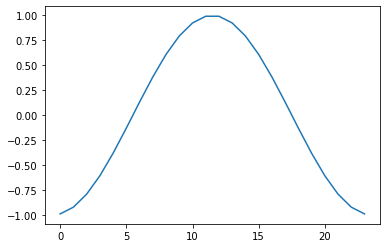

In [6]:
# temporal sine wave calculations
peaktime = 11.5  # UTC time, in hours, for the middle of the sunshine of the day, taken from time date website.
# zerotime = peaktime - 12
middle_offset = 5.5  # get this by solving Sin(peaktime...(and other factors))=1 at peaktime
daysinefn = lambda h: np.sin((h-middle_offset)/24*(2*np.pi))
daysinevals = daysinefn(np.arange(24))

plt.plot(np.arange(24),daysinevals)

In [7]:
# read in time outside calculation, both ways
exitdistthreshold=1500
savefile = resultsdir+'perdaytimeoutside_'+'day5min'+str(exitdistthreshold)+'.pklz'
dfoutside_5min = pickle.load(gzip.open(savefile,'rb'))

savefile = resultsdir+'perdaytimeoutside_'+'day1min'+str(exitdistthreshold)+'.pklz'
dfoutside_1min = pickle.load(gzip.open(savefile,'rb'))


In [ ]:
### CREATE DATA MATRIX.  Run this using the hour divisions as loaded above, not the 5 min divisions

# these are quantities which have just ONE VALUE per day.
perdayqs = ['Age', 'Day number', 'Bee unique ID', 'Cohort ID']

# these are quantities where the value should be a simple mean or a sum, NOT a weighted sum
simplemeanqs = ['Dispersion-minute avg.']
sumqs = ['Num. observations', 'Num. outside trips', 'Num. dance floor visits',
        'Frame 0 - Num. crossings',
       'Frame 1 - Num. crossings', 'Frame 2 - Num. crossings',
       'Frame 3 - Num. crossings', 'Frame 4 - Num. crossings',
       'Frame 5 - Num. crossings']
weightedmeanqs = ['Honey', 'Brood care', 'Pollen',
       'Dance floor', 'Other', 'Frame 0', 'Frame 1', 'Frame 2', 'Frame 3',
       'Frame 4', 'Frame 5', 'Median speed', 'Speed IQR',
       'Speed 90th quantile', 'Dispersion (avg)',
       'Exit distance (median)', 'Fraction squares visited', 
       'Festoon', 'Empty comb' # not sure if these exists for 2018.. might give an error
        ]
allquantitynames = np.concatenate((perdayqs,weightedmeanqs,sumqs,simplemeanqs,
                                   ['Speed circadian coeff.']))



### NEW WAY - USE DATAFRAME AND LOOP OVER DAYS AND BEES
# this is less efficient but it will work fine
dfday = pd.DataFrame(columns=allquantitynames)
dfblank = dfday.copy()
for daynum in daystoprocess:
    print(daynum)
    dfsel = df[df['Day number']==daynum]
    day_uids = np.unique(dfsel['Bee unique ID']).astype(int)
    for i in day_uids:
        dfbee = dfsel[dfsel['Bee unique ID']==i].copy()
        dfbee.sort_values(by=['Hour'],inplace=True)

        # get average values for this bee and put in the dataframe
        dftemp = dfblank.copy()
        # Create empty row to assign below
        dftemp.loc[0] = np.tile(np.nan,len(dftemp.columns))
        # single values
        for q in perdayqs:
            dftemp[q] = dfbee[q].iloc[0]
        # simple mean
        for q in simplemeanqs:
            dftemp[q] = np.nanmean(dfbee[q])
        # sum
        for q in sumqs:
            dftemp[q] = np.nansum(dfbee[q])
        # weighted mean
        for q in weightedmeanqs:
            dftemp[q] = np.nansum(dfbee[q] * dfbee['Num. observations']) / np.nansum(dfbee['Num. observations'])        
        # Speed circadian coeff - need to calculate
        dfbeespeedcirc = dfbee['Median speed'].values
        dfbeespeedcirc[np.isnan(dfbee['Num. observations'])] = np.nan
        dftemp['Speed circadian coeff.'] = np.nanmean(dfbeespeedcirc * daysinevals) / np.nanmean(dfbeespeedcirc)  # to normalize by hour-averaged speed
        dfday = pd.concat((dfday,dftemp))

dfday.reset_index(inplace=True,drop=True)
dfday = dfday.merge(dfoutside_5min, on=['Day number', 'Bee unique ID'])
dfday = dfday.merge(dfoutside_1min, on=['Day number', 'Bee unique ID'])
pickle.dump(dfday, gzip.open(resultsdir+'daydatamat'+'.pklz','wb'))
dfday.to_csv(resultsdir+'daydatamat'+'.csv')
print('wrote to file')

In [9]:
dfday

,Age,Day number,Bee unique ID,Cohort ID,Honey,Brood care,Pollen,Dance floor,Other,Frame 0,...,Frame 2 - Num. crossings,Frame 3 - Num. crossings,Frame 4 - Num. crossings,Frame 5 - Num. crossings,Dispersion-minute avg.,Speed circadian coeff.,Time outside day5min,Num. outside trips day5min,Time outside day1min,Num. outside trips day1min
0,22.0,0,4.0,1.0,0.045395,0.212332,0.008444,0.0,0.733829,0.000775,...,40.0,0.0,20.0,46.0,116.373039,-0.509029,0.0,0.0,0.010417,11.0
1,22.0,0,6.0,1.0,0.036709,0.187211,0.048712,0.0,0.727368,0.021694,...,84.0,2.0,36.0,104.0,156.944835,-0.565287,0.0,0.0,0.004167,6.0
2,22.0,0,7.0,1.0,0.255499,0.357586,0.042301,0.0,0.344614,0.000000,...,71.0,0.0,83.0,32.0,152.676205,-0.624841,0.0,0.0,0.000000,0.0
3,22.0,0,9.0,1.0,0.199898,0.162891,0.035332,0.0,0.601880,0.000000,...,43.0,1.0,29.0,63.0,167.909343,-0.580714,0.0,0.0,0.000000,0.0
4,22.0,0,11.0,1.0,0.068730,0.160821,0.045910,0.0,0.724540,0.004808,...,55.0,4.0,61.0,45.0,140.118809,-0.418582,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202704,33.0,115,8095.0,29.0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,...,0.0,0.0,0.0,0.0,NaN,0.382683,0.0,0.0,0.000000,0.0
202705,33.0,115,8144.0,29.0,0.000000,0.371179,0.000000,0.0,0.628821,0.000000,...,0.0,0.0,0.0,0.0,NaN,0.382683,0.0,0.0,0.000000,0.0
202706,29.0,115,8277.0,30.0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,...,0.0,0.0,0.0,1.0,NaN,0.382683,0.0,0.0,0.000000,0.0
202707,29.0,115,8427.0,30.0,0.972222,0.027778,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,NaN,0.382683,0.0,0.0,0.000000,0.0


# (5) Day histograms

In [ ]:
saveprefix='dayhour'
daynum=0
max_daynum=50
dfxyday = pd.DataFrame()
for daynum in range(max_daynum):
    print(daynum)
    [dfxy] = pickle.load(gzip.open(resultsdir+'dfxy_'+saveprefix+'_'+str(daynum).zfill(zfilln)+'.pklz','rb'))
    grouped = dfxy.groupby('Bee unique ID').sum()
    grouped['Day number'] = daynum
    grouped.drop(columns=['Hour', 'Cohort ID'],inplace=True)
    dfxyday = pd.concat([dfxyday,grouped])

In [ ]:
savefile = resultsdir+'dfxy_day.pklz'
pickle.dump(dfxyday,gzip.open(savefile,'wb'))

In [23]:
dfxyday

,Day number,hist0,hist1,hist2,hist3,hist4,hist5,hist6,hist7,hist8,...,hist1466,hist1467,hist1468,hist1469,hist1470,hist1471,hist1472,hist1473,hist1474,hist1475
Bee unique ID,,,,,,,,,,,,,,,,,,,,,
4.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5626.0,49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5627.0,49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5628.0,49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# (6) Convert pklz to compressed hdfs for upload

In [ ]:
daystoprocess = list(range(bd.numdays))

for numtimedivs in [24,288,1440]:
    if numtimedivs==24:
        prefix = 'dayhour'
    elif numtimedivs==288:
        prefix = 'day5min'
    elif numtimedivs==1440: 
        prefix = 'day1min'
    else: 
        print('ERROR:  use either numtimesteps == 24 or 288 or 1440')

    for daynum in daystoprocess:  #  
        # save to file
        outfile_base = resultsdir+'df_'+prefix+'_'+str(daynum).zfill(zfilln)
        [df] = pickle.load(gzip.open(outfile_base+'.pklz','rb'))
        df.to_hdf(outfile_base+'.hdf',complevel=9,key='df', mode='w')
        print('wrote to ',outfile_base)
        del df
        gc.collect()

        if (numtimedivs==24):
            outfile_base = resultsdir+'dfxy_'+prefix+'_'+str(daynum).zfill(zfilln)
            [dfxy] = pickle.load(gzip.open(outfile_base+'.pklz','rb'))
            dfxy.to_hdf(outfile_base+'.hdf',complevel=9,key='dfxy', mode='w')
            print('wrote xy df')
            del dfxy
            gc.collect()        

In [ ]:
# read in with:
# df = pd.read_hdf(outfile_base+'.hdf')

In [ ]:
# numtimedivs = 288  # each hour, or 5 min. For interactions, dont do 1 minute, its too much - use 5 min 
# for numtimedivs in [24,1440]:
#     if numtimedivs==24:
#         prefix = 'dayhour'
#     elif numtimedivs==288:
#         prefix = 'day5min'
#     elif numtimedivs==1440:
#         prefix = 'day1min'
#         print('ERROR:  use either numtimesteps == 24 or 288')

#     for daynum in range(bd.numdays):
#         print(daynum)
#         filename = resultsdir+'df_'+prefix+'_'+str(daynum).zfill(zfilln)+'.pklz'
#         [df] = pickle.load(gzip.open(filename,'rb'))
#         df['Day number'] = daynum
#         pickle.dump([df],gzip.open(filename,'wb'),protocol=4)

In [ ]:
# ## set nans.  Remember that needed to change 'timedivision' to 'Hour' for 24
# numtimedivs = 288  # each hour, or 5 min. For interactions, dont do 1 minute, its too much - use 5 min 

# if numtimedivs==24:
#     prefix = 'dayhour'
# elif numtimedivs==288:
#     prefix = 'day5min'
# elif numtimedivs==1440:
#     prefix = 'day1min'
#     print('ERROR:  use either numtimesteps == 24 or 288')

# for daynum in range(bd.numdays):
#     print(daynum)
#     filename = resultsdir+'df_'+prefix+'_'+str(daynum).zfill(zfilln)+'.pklz'
#     [df] = pickle.load(gzip.open(filename,'rb'))
#     # fill in nans for quantities, where num obs is nan.
#     fornanfill = df.columns.drop(['Age','Bee unique ID','Cohort ID','timedivision','Day number'])
#     nanlocs = np.isnan(df['Num. observations'])
#     df.loc[nanlocs,fornanfill] = np.nan
#     pickle.dump([df],gzip.open(filename,'wb'),protocol=4)